# CartPole-v0 Enviroment 

In [48]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

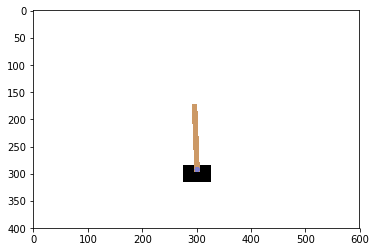

In [49]:
env = gym.make("CartPole-v0").env
env.reset()
plt.imshow(env.render('rgb_array'))

In [50]:
print(env.observation_space)
print(env.action_space)
n_actions= env.action_space.n

Box(4,)
Discrete(2)


Note: each observation of this enviroment is a 4-dimension vector : 0-cart position; 1-cart velocity; 2-pole angel; 3-pole velocity at tip

# Neural Net Agent 

Use a multi-layer perceptron model to map states and actions.

Initially the policy (state-action mapping) is random.

After each elite-sessions selection, the curve fitting(policy)is updates.

In [51]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                     activation='tanh',
                     warm_start=True,
                     max_iter=1)
agent.fit([env.reset()]*n_actions,list(range(n_actions)))

/home/ubunturobot/Desktop/project0/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [52]:
# each sessuion is one data point in the curve-fitting
def generate_session(t_max=1000):
    states,actions = [],[]
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(np.arange(n_actions),p = probs)
        new_s,r,done,info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states,actions,total_reward

In [53]:
# essential CEM step: keep the high reward sessions(data points)
def select_elites(states_batch, actions_batch, rewards_batch,percentile=50):
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states  = np.array(states_batch)[rewards_batch >= reward_threshold]
    elite_states = [y for x in elite_states for y in x]
    elite_actions = np.array(actions_batch)[rewards_batch >= reward_threshold]
    elite_actions = [y for x in elite_actions for y in x]
    
    return elite_states,elite_actions

In [54]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 993.620, threshold=1000.000


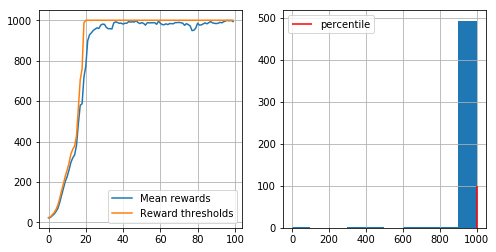

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000.  648. 1000. 1000. 1000. 1000. 1000. 1000.  749. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 10

In [55]:
# each batch generate 500 data points
# then select top 70% the high reward data points to re-fit curve (policy)
# then generate the next batch with updated policy
# total of 100 interactions in this example
n_sessions = 500
percentile = 70
log = []
for i in range(100):
    sessions = [generate_session() for _ in range(n_sessions)]
    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    elite_states,elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)
    agent.fit(elite_states, elite_actions) # update the agent with elite sessions' state-action mapping
    show_progress(batch_rewards,log,percentile,reward_range=[0,np.max(batch_rewards)])
    print(batch_rewards)
    if np.mean(batch_rewards)>190:
        print('You win! You may stop training now via KeyboardInterrupt.')